In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [1]:
import pandas as pd 
import numpy as np
import torch
import pytorch_lightning as pl
from pathlib import Path
from tqdm.notebook import tqdm
from torch import nn, optim

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar

In [31]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

### Notebook parameters

In [2]:
# DATA_PATH = Path('/content/drive/MyDrive/krafthack/data')
DATA_PATH = Path('./data/')
TEST_SPLIT_SIZE = .2
SEED = 125501
N_EPOCHS=3
FRAC=.5

In [3]:
df = pd.read_parquet(DATA_PATH / 'input_dataset-2.parquet')

## Features generation

In [4]:
FEATURE_COLUMNS = df.columns.tolist()[:7]
LABEL_COLUMN = 'Bolt_4_Tensile'

In [5]:
pl.seed_everything(seed=SEED)

Global seed set to 125501


125501

In [6]:
def add_elapsed(df):
    """elapsed time since last start"""
    df["_t"] = df.index

    df["_change"] = ~(df["mode"] == df["mode"].shift(1))
    # mimics start at t=0 --> wrong -> impute value instead
    df["_change"].iloc[0]=True
    df["elapsed"] = (df['_t']-df['_t'].where(df["_change"]).ffill()).dt.total_seconds()

    # impute values for first interval (as it starts at "operational" state)
    i_first_start = df.index.get_loc(df.index[df["mode"] == 1][0])
    df.iloc[:i_first_start]["elapsed"] += df["elapsed"].mean()

    del df['_t']
    del df['_change']


In [7]:
features_df = df.head(int(df.shape[0] * FRAC))[FEATURE_COLUMNS].copy()

features_df.dropna(inplace=True)

features_df['label'] = df[LABEL_COLUMN]

mode_le = LabelEncoder()

features_df['mode'] = mode_le.fit_transform(features_df['mode'].values)

In [8]:
train_df, test_df = train_test_split(features_df, test_size=TEST_SPLIT_SIZE, shuffle=False)

In [10]:
add_elapsed(train_df)
add_elapsed(test_df)

FEATURE_COLUMNS += ["elapsed"]

/var/folders/0p/6psgtqh579n2lzfbrm58bhbm0000gn/T/ipykernel_1256/278400515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_change"].iloc[0]=True
/var/folders/0p/6psgtqh579n2lzfbrm58bhbm0000gn/T/ipykernel_1256/278400515.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:i_first_start]["elapsed"] += df["elapsed"].mean()
/var/folders/0p/6psgtqh579n2lzfbrm58bhbm0000gn/T/ipykernel_1256/278400515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(train_df) # scale fit only on train, to remove data

train_df = pd.DataFrame(
    scaler.transform(train_df), index=train_df.index, columns=train_df.columns
)

test_df = pd.DataFrame(
    scaler.transform(test_df), index=test_df.index, columns=test_df.columns
)

In [13]:
print(train_df.shape)
print(test_df.shape)

(748599, 9)
(187150, 9)


In [14]:
def create_sequences(input_data: pd.DataFrame, feature_columns, target_column, sequence_length=60):
    sequences = []
    data_size = len(input_data)

    sequence_ = input_data[feature_columns][:sequence_length].to_numpy().tolist()
    all_labels = input_data[target_column].to_list()

    for i in tqdm(range(1, data_size - sequence_length)):
        row_dict = input_data.iloc[i].to_dict()
        feats = [row_dict[x] for x in feature_columns]

        sequence_.pop(0)
        sequence_.append(feats)

        label_position = i + sequence_length
        label = all_labels[label_position]
        sequences.append((sequence_.copy(), label))

    return sequences

In [15]:
train_sequences = create_sequences(train_df, FEATURE_COLUMNS, 'label')

  0%|          | 0/748538 [00:00<?, ?it/s]

In [16]:
test_sequences = create_sequences(test_df, FEATURE_COLUMNS, 'label')

  0%|          | 0/187089 [00:00<?, ?it/s]

## Dataset wrappers

In [17]:
class KrafthackDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence), label=torch.tensor(label)
        )


In [18]:
class KrafthackDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=256):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self):
        self.train_dataset = KrafthackDataset(self.train_sequences)
        self.test_dataset = KrafthackDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers=1)


In [19]:
data_module = KrafthackDataModule(
    train_sequences=train_sequences, test_sequences=test_sequences, batch_size=256
)

data_module.setup()

In [20]:
class TensilePredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden=64, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.25,
        )

        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)

        logits = hidden[-1]

        return self.regressor(logits)


In [21]:
class TensilePredictor(pl.LightningModule):
    def __init__(self, n_features: int):
        super().__init__()

        self.model = TensilePredictionModel(n_features)

        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0

        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, _ = self(sequences, labels)
        self.log("training_loss", loss, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, _ = self(sequences, labels)
        self.log("validation_loss", loss, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, _ = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)


In [22]:
model = TensilePredictor(n_features = train_df.shape[1] - 1)

In [24]:
checkpoint_callback = ModelCheckpoint(
    dirpath=".",
    filename="best_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="validation_loss",
    mode="min",
)

logger = TensorBoardLogger("lightning_logs", name="tensile-pred")

progress_callback = TQDMProgressBar(refresh_rate=30)

early_stopping_callback = EarlyStopping(
    monitor="validation_loss",
    patience=2
)

trainer = pl.Trainer(
    logger=logger,
    enable_checkpointing=True,
    callbacks=[early_stopping_callback, progress_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    # gpus=1
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
trainer.fit(model, data_module)


/Users/yoandinkov/Desktop/hackathon/code/.venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
Missing logger folder: lightning_logs/tensile-pred

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | TensilePredictionModel | 52.3 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
/Users/yoandinkov/Desktop/hackathon/code/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/yoandinkov/Desktop/hackathon/code exists and is not empty.
  rank_zero_warn(f"Checkpo

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/yoandinkov/Desktop/hackathon/code/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'KrafthackDataset' on <module '__main__' (built-in)>


## model evaluation

In [93]:
checkpoint_path = trainer.checkpoint_callback.best_model_path

print('Loading: ', checkpoint_path)

trained_model = TensilePredictor.load_from_checkpoint(checkpoint_path, 
                                                      n_features=train_df.shape[1] - 1)

Loading:  /content/best_checkpoint-v1.ckpt


In [94]:
trained_model.freeze()

In [96]:
td = KrafthackDataset(test_sequences)

predictions = []
labels = []

for item in td:
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

In [97]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [98]:
predicitons_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

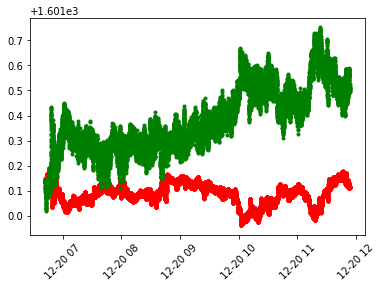

In [99]:
test_sequences_data = test_df[61:]
dates = matplotlib.dates.date2num(test_sequences_data.index.tolist())
plt.plot_date(dates, predicitons_descaled, '.', label='predicted', color='r')
plt.plot_date(dates, labels_descaled, '.', label='actual', color='g')
plt.xticks(rotation=45);

In [103]:
test_sequences_data

df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,Bolt_1_Steel tmp,Bolt_1_Tensile,Bolt_2_Tensile,...,Bolt_5_Tensile,Bolt_6_Tensile,Bolt_1_Torsion,Bolt_2_Torsion,Bolt_3_Torsion,Bolt_4_Torsion,Bolt_5_Torsion,Bolt_6_Torsion,lower_bearing_vib_vrt,turbine_bearing_vib_vrt
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-19 09:51:44,262.204308,2.899036,82.279976,173.955216,5310.799181,107.964278,operation,4.133996,1598.481390,1480.989917,...,1635.585700,1674.848803,175.758460,163.956613,146.288741,225.535170,297.780208,161.148100,NaN,NaN
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation,4.134078,1598.477449,1480.989528,...,1635.588478,1674.823883,175.755164,163.951680,146.284164,225.527142,297.771627,161.145094,NaN,NaN
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation,4.134731,1598.479316,1481.003188,...,1635.583464,1674.841318,175.764601,163.952007,146.283423,225.522291,297.777115,161.144487,NaN,NaN
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation,4.134270,1598.490184,1481.028827,...,1635.581384,1674.843245,175.763157,163.953924,146.283633,225.535827,297.772578,161.144037,NaN,NaN
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,operation,4.133583,1598.494073,1481.059017,...,1635.591746,1674.872300,175.760959,163.951968,146.286946,225.534231,297.774191,161.151967,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,operation,4.193937,1637.386115,1504.557822,...,1640.704071,1690.014705,183.204777,178.082932,145.759475,225.351989,300.667011,160.949816,0.159366,0.491265
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,operation,4.193254,1637.365865,1504.546091,...,1640.711250,1690.017029,183.203293,178.082287,145.766584,225.348279,300.674243,160.947868,0.155962,0.497242
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,operation,4.193261,1637.384133,1504.538696,...,1640.699142,1690.002008,183.212397,178.081678,145.764007,225.354785,300.674078,160.947644,0.141150,0.501525
